# Описание проекта

В нашем распоряжении данные о глобальных продажах видеоигр с 1980 по 2016 год.

В нашем анализе мы
- изучим динамику продаж
- определим средний срок жинзи платформы
- определим потенциально прибыльные платформы на следюущий год
- изучим влияние оценок критиков и пользователей на продажи
- изучим средние и медианные продажи по жанрам
- составим портрет покупателя в Сервеной Америке, Европе и Японии
- проверим
    - равны ли средние пользовательские рейтинги на PC и Xbox One
    - равны ли средние пользовательские рейтинги жанров Action и Sports

# 1. Получение данных, изучение общей информации

In [1]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

Откроем датасет и создадим его копию

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
df_original = df
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Данные прочитаны без ошибок. Изучим общую информацию

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

Наибольшие проблемы в данных:
- значительное число пропусков (40-50%) в столбцах с оценками и возрастными рейтингами
- `user_score` имеет нечисловой тип

# 2. Предобработка данных

Приведём названия столбцов к нижнему регистру

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проведём предобработку - обработаем пропуски и заменим типы данных при необходимости.

У двух записей отсутствует имя и платформа.

In [6]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Этих записей всего две - можно удалить их без последствий

In [7]:
df = df.dropna(subset = ['name'])

В нашем исследовании год релиза - один из основных параметров, по которому мы будем определять актуальность данных и динамику продаж, поэтому записи с пропущенным годом нас не интересуют. Удалим их и проверим, сколько процентов от исходого датасета у нас осталось

In [8]:
df = df.dropna(subset = ['year_of_release'])
df.shape[0] / df_original.shape[0]

0.9837870176488184

Удалено менее двух процентов данных. Теперь, поскольку `year_of_release` не содержит пропусков, можно привести его к селочисленному типу

In [9]:
df['year_of_release'] = df['year_of_release'].astype(int)
df['year_of_release'].value_counts().head()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
Name: year_of_release, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Заполнить пропуски в оценках и рейтингах мы не можем, поэтому оставим их без изменений.

`user_score` имеет нечисловой тип данных, взглянем на него поближе

In [11]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Значение tbd (to be determined) - строковое. Вероятнее всего в источнике данных таким образом помечались игры без рейтинга. Заменить его каким-либо значением невозможно, поэтому заменим его на `None`, заодно и изменив тип данных

In [12]:
df['user_score'] = pd.to_numeric(df['user_score'], errors = 'coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


**Предобработка завершена.**
- В общей сложности удалено <2% значений. Основная причина удаления - отсутствующий год релиза.
- Изменены типы данных в следующих столбцах:
    - `year_of_release` с `float` на `int`
    - `user_score` со `string` на `int`**

<a id="duplicates"></a>

Проверка на явные дубликаты

In [13]:
df.duplicated().sum()

0

**Полностью дублирующихся записей не обнаружено не обнаружено**


In [14]:
pd.Series(df['platform'].unique()).duplicated().sum()

0

**Дубликатов среди названий платформ не обнаружено**

In [15]:
pd.Series(df['genre'].unique()).duplicated().sum()

0

**Дубликатов среди названий жанров не обнаружено**

In [16]:
df['name'] = df['name'].str.lower()
df['name'].duplicated().sum()

5018

Обнаружено 5000 дублирующихся имён. Скорее всего это мультиплатформенные релизы. Проверим это, сделав группировку по платформам

In [17]:
(df.groupby('platform')['name'].value_counts() > 1).sum()

3

Есть три дубликата по имени и платформе

In [18]:
dupl_group = df.groupby('platform')['name'].value_counts() > 1
dupl_group[dupl_group.values == True]

platform  name                       
PC        need for speed: most wanted    True
PS3       madden nfl 13                  True
X360      need for speed: most wanted    True
Name: name, dtype: bool

In [19]:
df[(df['name'] == 'need for speed: most wanted') & (df['platform'].isin(['PC', 'X360']))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,need for speed: most wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,need for speed: most wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
5972,need for speed: most wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,need for speed: most wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T


Две игры под названием `need for speed: most wanted` действительно выходили в 2005 и 2012 году

In [20]:
df[(df['name'] == 'madden nfl 13') & (df['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,madden nfl 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


А вот это уже дубликат. Можно удалить вторую запись, сохранив суммарные значения продаж в первой

In [21]:
df.loc[604, 'eu_sales'] += 0.01
df = df.drop(16230)
df[(df['name'] == 'madden nfl 13') & (df['platform'] == 'PS3')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,PS3,2012,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


**Обнаружен и удалён 1 дубликат по имени**

# 3. Исследовательский анализ данных

Изучим распределение продаж по годам

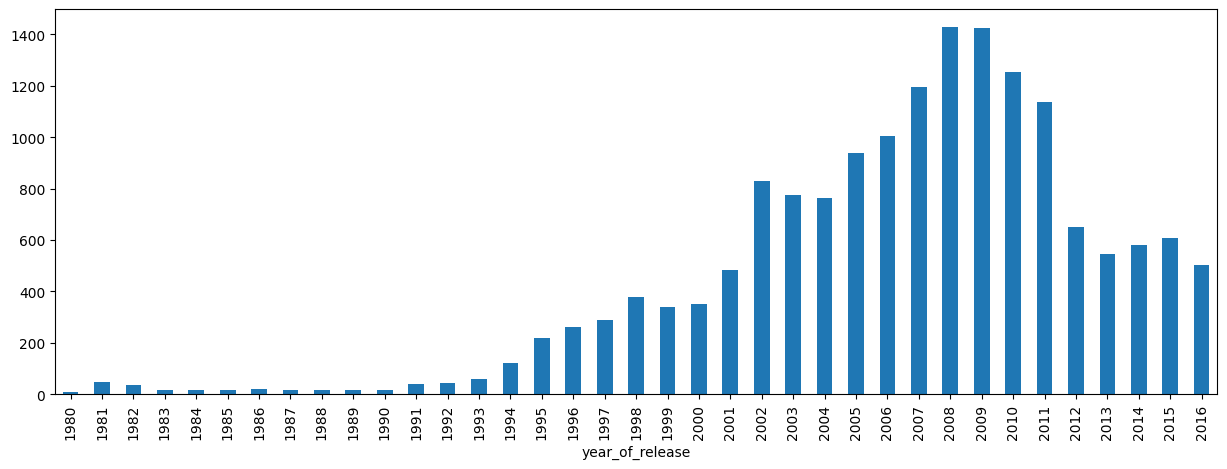

In [22]:
df.groupby('year_of_release')['name'].count().plot(kind = 'bar', figsize=(15,5));

**До 2008-2009 годов наблюдался тренд к росту продаж, после чего, с 2010 года начинается резкий спад. Вероятнее всего - это последствия финансового кризиса 2008 года. Докризисные данные будут бесполезны в нашем анализе, поэтому в первом приближении будем считать актуальными данные, начиная с 2012 года**

In [23]:
year_threshold = 2012

Для анализа динамики продаж добавим столбец с суммарными продажами

In [24]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Изучим динамику продаж по платформам. Для этого выберем топ-10 платформ по суммарным продажам

In [25]:
top_platforms_groupby = df.groupby('platform')['total_sales'].agg(['count', 'sum']).\
sort_values(by = 'sum', ascending = False).head(10)

top_platforms_groupby

,count,sum
platform,,
PS2,2127,1233.56
X360,1232,961.24
PS3,1305,931.34
Wii,1286,891.18
DS,2121,802.78
PS,1190,727.58
PS4,392,314.14
GBA,811,312.88
PSP,1193,289.53


<Axes: xlabel='year_of_release'>

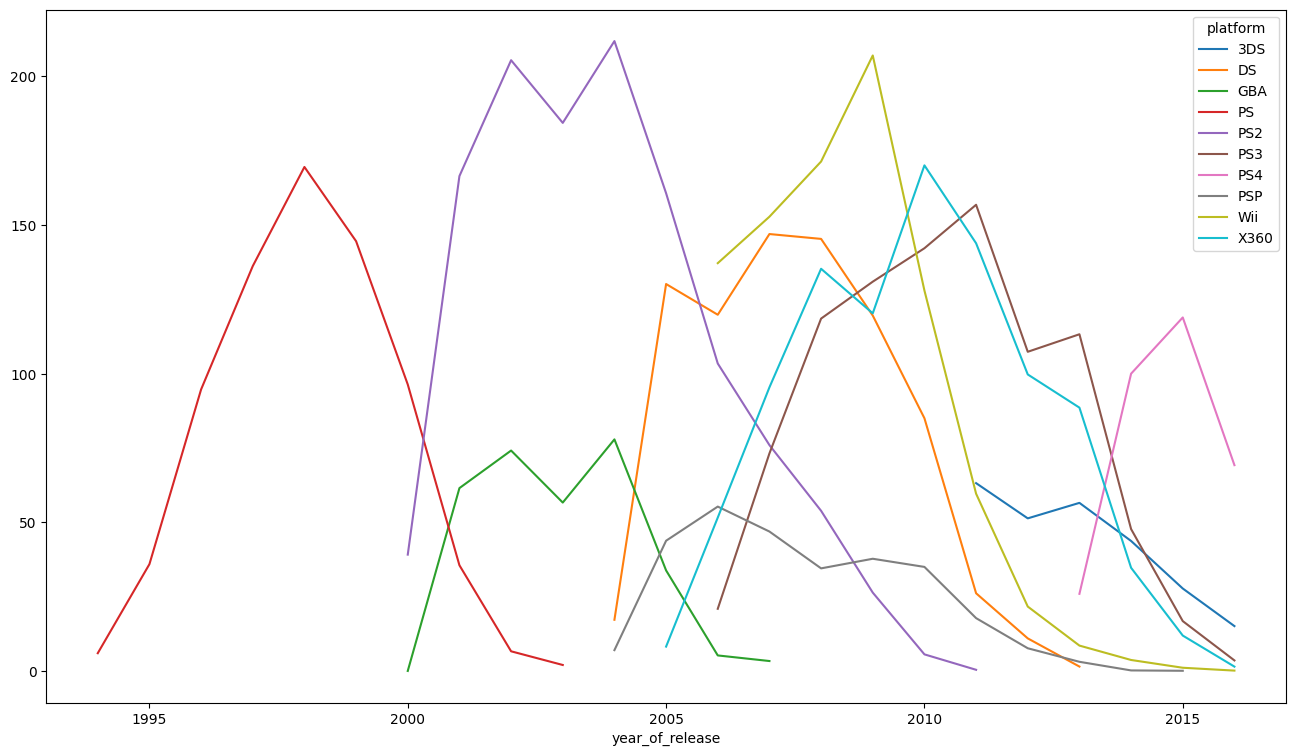

In [26]:
top_platforms_sales = df[df['platform'].isin(top_platforms_groupby.index)]
top_platforms_sales.groupby(['platform', 'year_of_release'])['total_sales'].sum().unstack().T.\
plot(figsize = (16, 9), xlim = (1993, 2017))

**Продажи по разным платформам ведут себя похожим образом - рост после релиза, за котрым (примерно с середины жизненного цикла платформы) идёт спад. Изучим прожолжительность жизненного цикла платформ**

In [27]:
platforms_age_group = df.groupby('platform')['year_of_release'].agg(['count', 'min', 'max'])
platforms_age_group['lifespan'] = platforms_age_group['max'] - platforms_age_group['min']
platforms_age_group.head()

,count,min,max,lifespan
platform,,,,
2600,116,1980,1989,9
3DO,3,1994,1995,1
3DS,512,2011,2016,5
DC,52,1998,2008,10
DS,2121,1985,2013,28


Удалим из группировки платформы с малым количеством упоминаний (<100), а также все платформы, активные в изучаемый период (т. к. их жизненный цикл ещё не окончен)

In [28]:
dead_platforms = platforms_age_group[(platforms_age_group['count'] > 100) & (platforms_age_group['max'] < 2016)]
dead_platforms

,count,min,max,lifespan
platform,,,,
2600,116,1980,1989,9
DS,2121,1985,2013,28
GBA,811,2000,2007,7
GC,542,2001,2007,6
N64,316,1996,2002,6
PS,1190,1994,2003,9
PS2,2127,2000,2011,11
PSP,1193,2004,2015,11
SAT,173,1994,1999,5


In [29]:
dead_platforms['lifespan'].describe()

count    11.000000
mean      9.909091
std       6.315925
min       5.000000
25%       6.500000
50%       9.000000
75%      10.000000
max      28.000000
Name: lifespan, dtype: float64

**Средний жизненный цикл платформы - 10 лет.**

**Если принять за точку отсчёта 10-летний срок жизни платформы, то необходимо взять данные с 2006 года, однако выше мы видим, что МФК 2008 года сильно повлиял на динамику прожаж, поэтому было бы некорректно использовать эти данные, поэтому продолжим анализ с данными с 2012 года**

In [30]:
df_actual = df[df['year_of_release'] >= year_threshold].reset_index(drop = True)
df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,grand theft auto v,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,grand theft auto v,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,pokemon x/pokemon y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,call of duty: black ops ii,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


Посмотрим, какие платформы оказались в нашем срезе

In [31]:
df_actual['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

Изучим жизненный цикл этих платформ

In [32]:
actual_platforms_group = platforms_age_group[platforms_age_group.index.isin(df_actual['platform'].unique())]\
.sort_values(by = 'lifespan')
actual_platforms_group

,count,min,max,lifespan
platform,,,,
PS4,392,2013,2016,3
XOne,247,2013,2016,3
WiiU,147,2012,2016,4
3DS,512,2011,2016,5
PSV,429,2011,2016,5
PS3,1305,2006,2016,10
Wii,1286,2006,2016,10
PSP,1193,2004,2015,11
X360,1232,2005,2016,11


Около половины платформ находятся в конце своего жизненного цикла. Изучим динамику продаж на платформах, находящихся в середине жизненного цикла (кроме того, добавим PC, поскольку из-за специфики платформы в данном случае было бы некорректно говорить о "жизненном цикле")

In [33]:
alive_platforms = list(actual_platforms_group.head().index)
alive_platforms.append('PC')
alive_platforms

['PS4', 'XOne', 'WiiU', '3DS', 'PSV', 'PC']

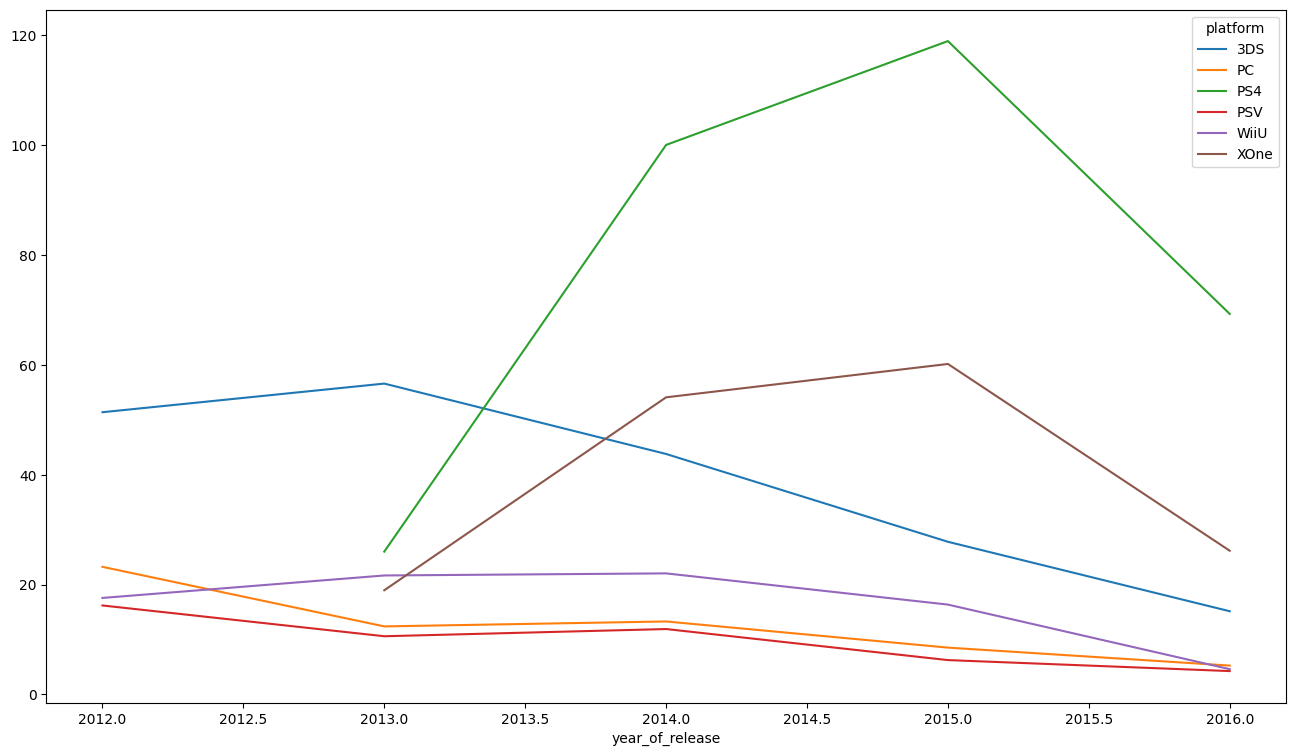

In [34]:
df_actual[df_actual['platform'].isin(alive_platforms)].groupby(['platform', 'year_of_release'])['total_sales'].sum().\
unstack().T.plot(figsize = (16, 9));

**В целом, все платформы показывают падение продаж. Наиболее высокие продажи на данный момент - у PS4 и XOne**

Построим боксплоты для наших "живых" платформ

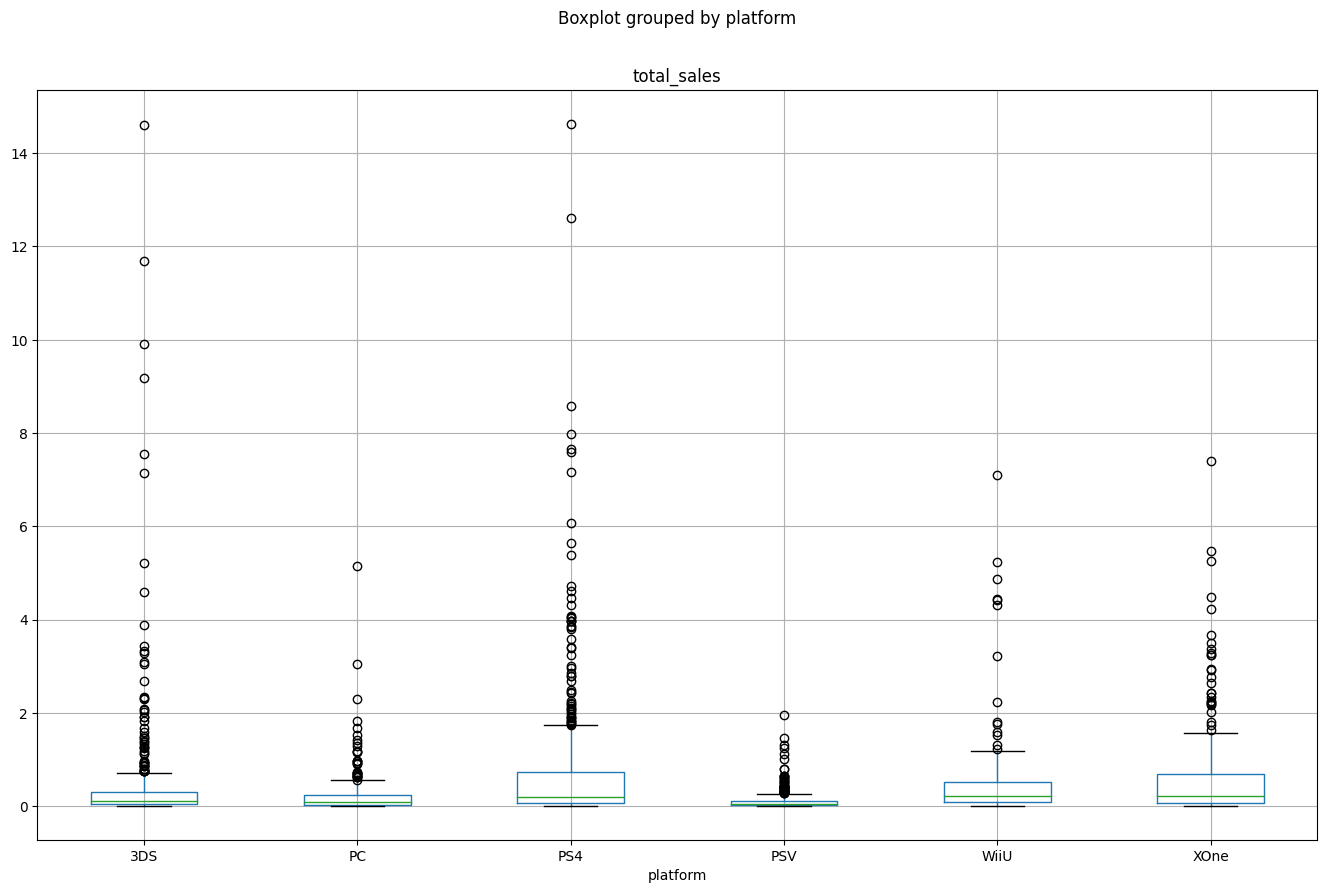

In [35]:
alive_platforms_group = df_actual[df_actual['platform'].isin(alive_platforms)]
alive_platforms_group.boxplot(column ='total_sales', by = 'platform', figsize = (16, 10));

<a id="boxplot"></a>

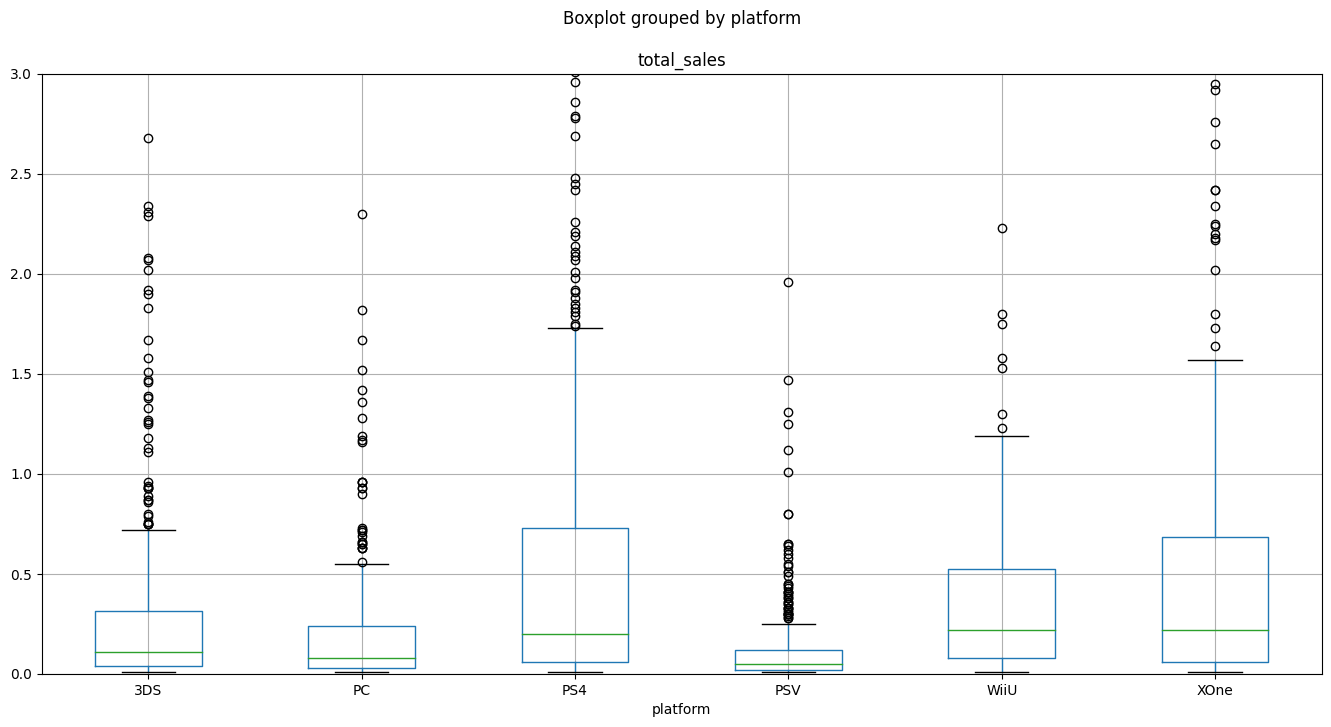

In [36]:
alive_platforms_group.boxplot(column ='total_sales', by = 'platform', figsize = (16, 8)).set_ylim(0, 3);

На графике видно, что PS4 и Xone имеют близкие медиану и 3 квартиль, однако у PS4 больший IQR и большее количество "выбросов".

**PS4 потенциально прибыльнее**

Изучим взаимосвязь между оценками пользователей / критиков и продажами. Для этого расчитаем коэффициент корреляции и построим диаграммы разброса

In [37]:
def corr_and_scatter(platform):
    print('оценки пользователей')
    print('корреляция', df_actual[df_actual['platform'] == platform]['total_sales'].corr(df_actual['user_score']))
    df_actual[df_actual['platform'] == platform].plot(y = 'total_sales', x = 'user_score', kind = 'scatter')
    print('оценки критиков')
    print('корреляция', df_actual[df_actual['platform'] == platform]['total_sales'].corr(df_actual['critic_score']))
    df_actual[df_actual['platform'] == platform].plot(y = 'total_sales', x = 'critic_score', kind = 'scatter')

оценки пользователей
корреляция -0.031957110204556424
оценки критиков
корреляция 0.406567902061781


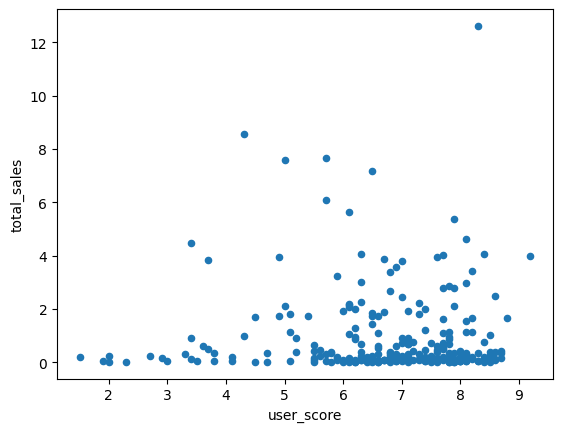

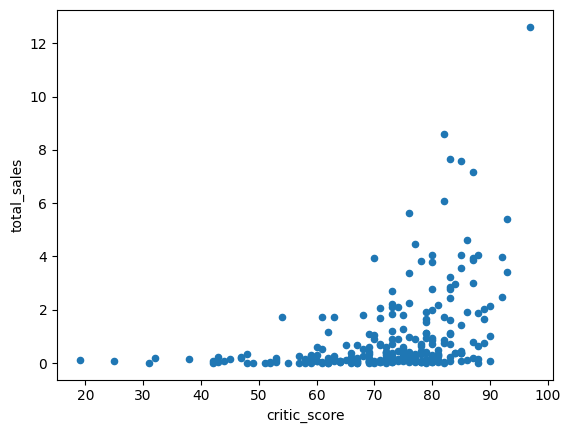

In [38]:
corr_and_scatter('PS4')

оценки пользователей
корреляция -0.06892505328279412
оценки критиков
корреляция 0.41699832800840175


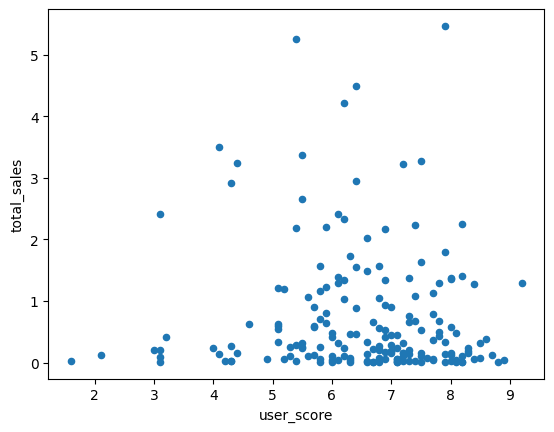

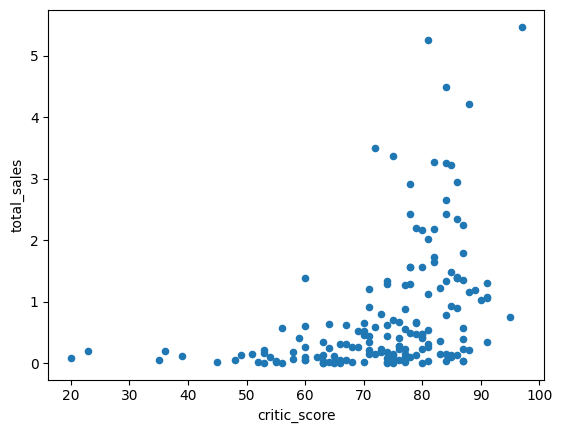

In [39]:
corr_and_scatter('XOne')

оценки пользователей
корреляция 0.19758263411038596
оценки критиков
корреляция 0.32080286953607845


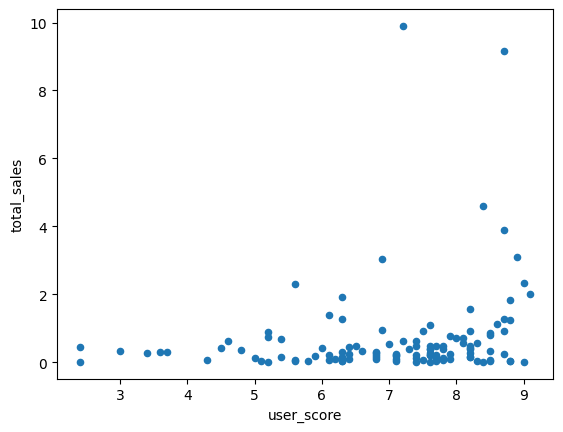

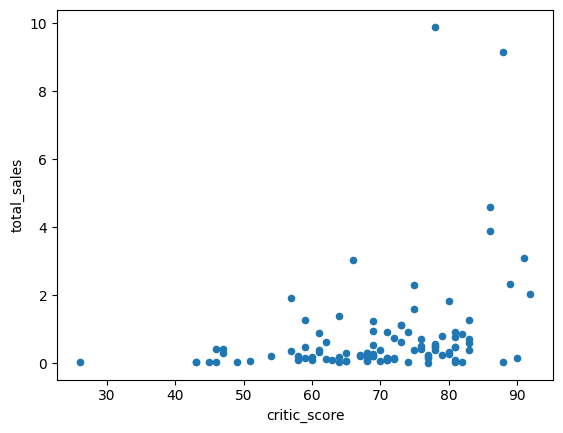

In [40]:
corr_and_scatter('3DS')

**Можно видеть, что оценки пользователей не влияют (либо слабо влияют) на продажи, т.к. коэффициент корреляции низок, точки на диаграмме разбросаны хаотично. Рейтинг критиков же имеет более высокий коэффициент корреляции, а точки на диаграммах более упорядочены (точки с высокими продажами скапливаются в правой части графика)**

Изучим распределение игр по жанрам

<Axes: >

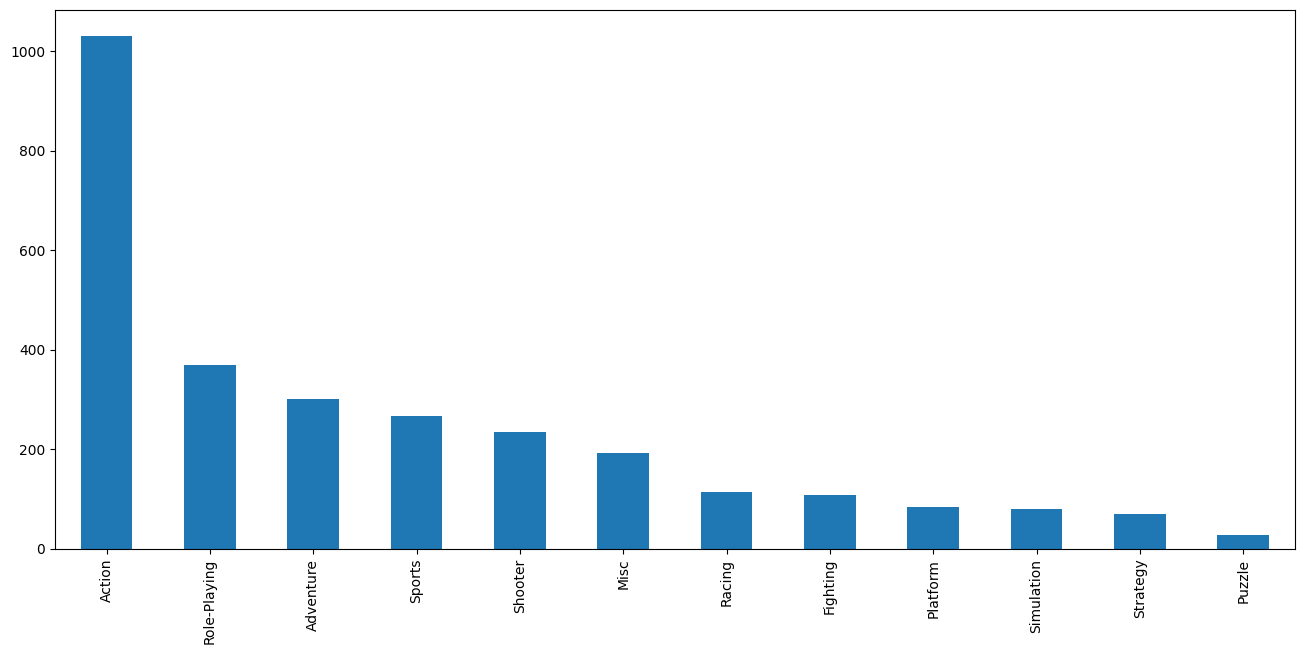

In [41]:
df_actual['genre'].value_counts().plot(kind = 'bar', figsize = (16, 7))

Игр в жанре экшн выходит значительно больше остальных. Меньше всего выпускается платформеров, симуляторов, стратегий и головоломок. Изучим продажи по жанрам

In [42]:
sales_groupby = df_actual.groupby('genre')['total_sales'].\
agg(['count', 'sum', 'mean', 'median']).sort_values(by = 'mean', ascending = False)
sales_groupby

,count,sum,mean,median
genre,,,,
Shooter,235,304.73,1.296723,0.440
Platform,85,61.00,0.717647,0.210
Sports,267,181.07,0.678165,0.240
Role-Playing,370,192.80,0.521081,0.140
Racing,115,53.50,0.465217,0.140
Misc,192,85.04,0.442917,0.120
Simulation,80,35.12,0.439000,0.120
Action,1031,441.12,0.427856,0.120
Fighting,109,44.49,0.408165,0.130


<Axes: xlabel='genre'>

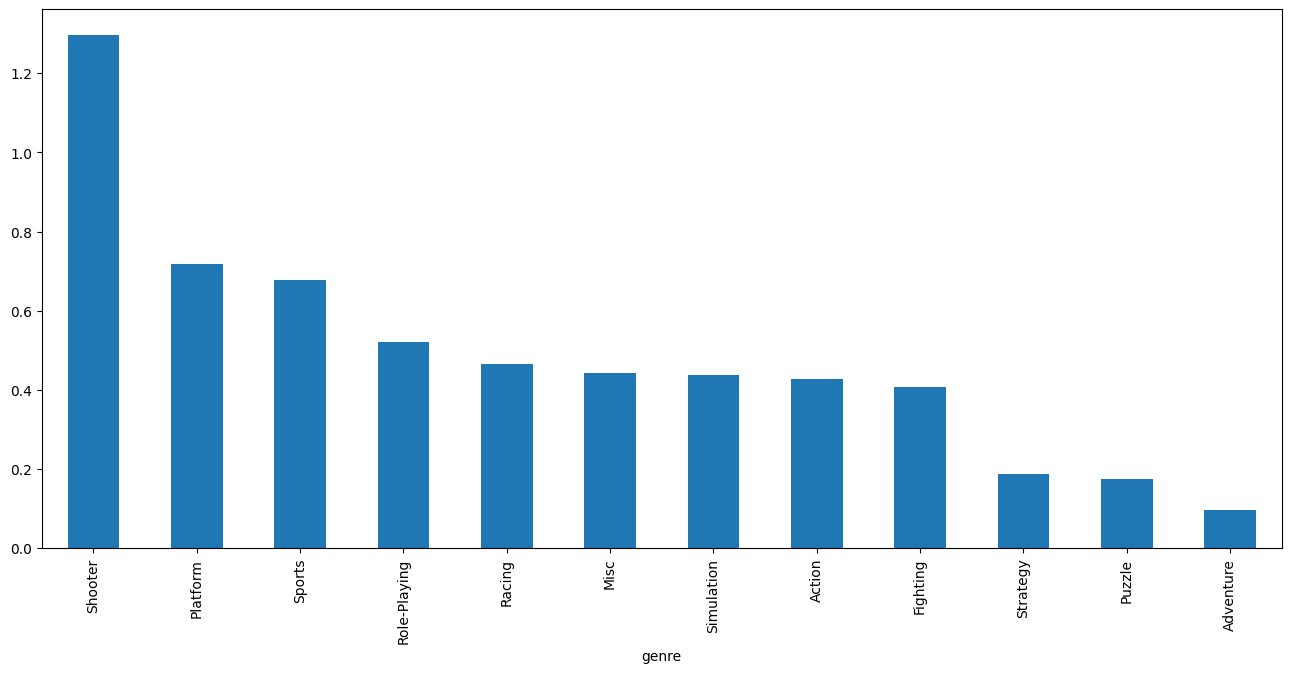

In [43]:
sales_groupby['mean'].sort_values(ascending = False).plot(kind = 'bar', figsize = (16, 7))

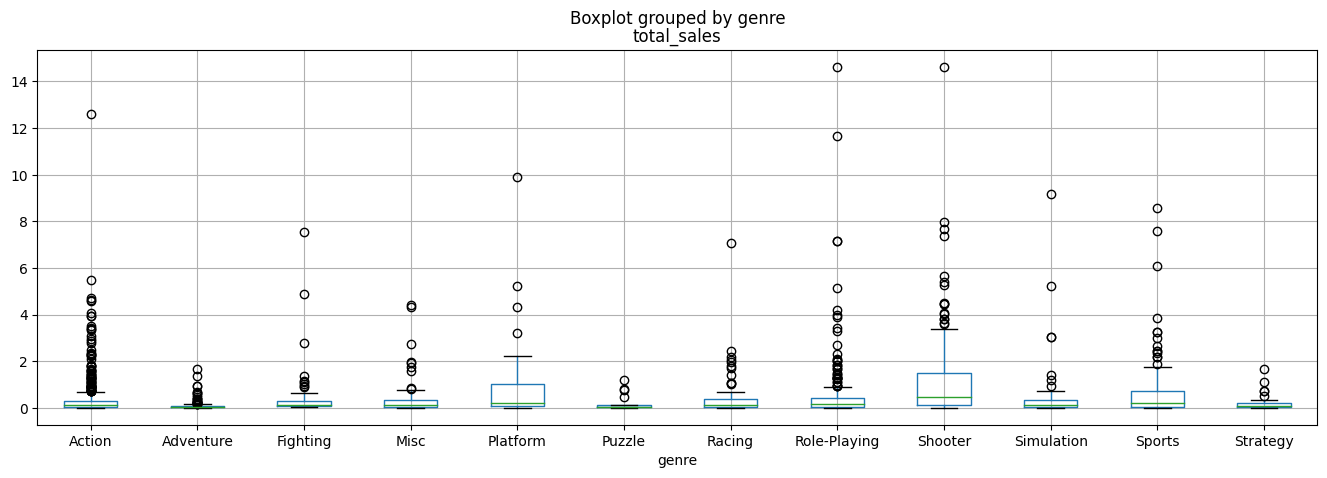

In [44]:
alive_platforms_group.boxplot(column ='total_sales', by = 'genre', figsize = (16, 5));

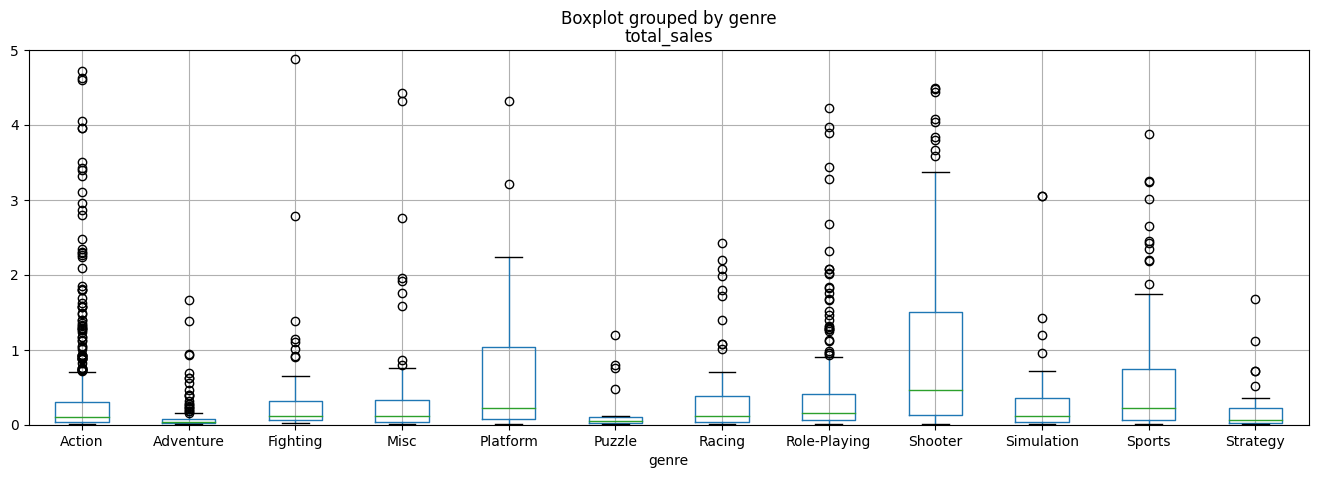

In [45]:
alive_platforms_group.boxplot(column ='total_sales', by = 'genre', figsize = (16, 5)).set_ylim(0, 5);

**Наилучшие средние и медианные продажи показывают игры-шутеры. Кроме того, среди них потенциально большее число бестселлеров (3 квартиль IQR заметно выше остальных). За шутерами следуют спортивные игры и платформеры**

# 4. Исследование региональных продаж

Рассмотрим различие в популярности платформ по регионам

In [46]:
def get_top_5_old(column):
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].set_title('Северная Америка')
    df_actual.groupby(column)['na_sales'].sum().sort_values(ascending = False).head(5).plot(kind = 'bar', grid = True, ax = axs[0])
    axs[1].set_title('Европа')
    df_actual.groupby(column)['eu_sales'].sum().sort_values(ascending = False).head(5).plot(kind = 'bar', grid = True, ax = axs[1])
    axs[2].set_title('Япония')
    df_actual.groupby(column)['jp_sales'].sum().sort_values(ascending = False).head(5).plot(kind = 'bar', grid = True, ax = axs[2])
    plt.show()

<div class="alert alert-info">
<b>Комментарий для github:</b>
<br> Вторая версия функции с пайчартами была добавлена по замечанию ревьюера (см. ниже). Я не считаю её удобной для анализа.
</div>

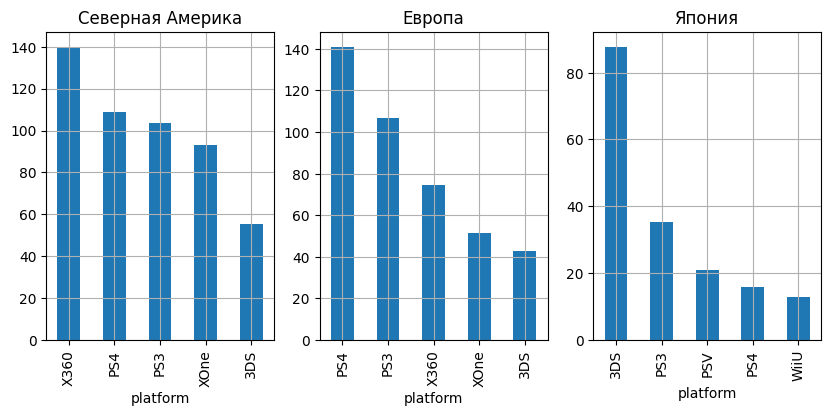

In [47]:
get_top_5_old('platform')

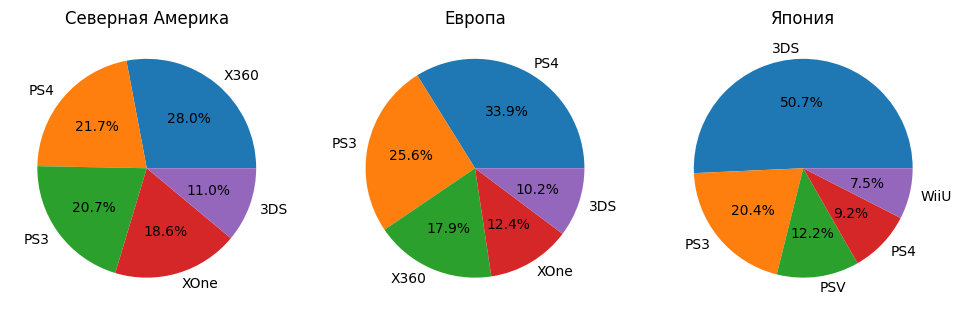

In [48]:
def get_top_5(column):
    fig, axs = plt.subplots(1, 3, figsize=(12, 12))
    data = df_actual.groupby(column)['na_sales'].sum().sort_values(ascending = False).head(5).values
    names = df_actual.groupby(column)['na_sales'].sum().sort_values(ascending = False).head(5).index
    axs[0].pie(data, labels = names, autopct='%1.1f%%')
    axs[0].set_title('Северная Америка')
    data = df_actual.groupby(column)['eu_sales'].sum().sort_values(ascending = False).head(5).values
    names = df_actual.groupby(column)['eu_sales'].sum().sort_values(ascending = False).head(5).index
    axs[1].pie(data, labels = names, autopct='%1.1f%%')
    axs[1].set_title('Европа')
    data = df_actual.groupby(column)['jp_sales'].sum().sort_values(ascending = False).head(5).values
    names = df_actual.groupby(column)['jp_sales'].sum().sort_values(ascending = False).head(5).index
    axs[2].pie(data, labels = names, autopct='%1.1f%%')
    axs[2].set_title('Япония')
get_top_5('platform')

<div class="alert alert-warning">
<h2> Комментарий ревьюера V1<a class="tocSkip"> </h2>

<b>Некоторые замечания и рекомендации💡:</b> Можно было построить круговые диаграммы и воспользоваться методом subplots(), чтобы вывести графики в одном полотне и в одном ряду, чтобы они помещались вместе на экране.

**В Североамериканском регионе популярнее всего Xbox 360 (возможно в силу того, что это консоль американского производства). Игры PS3, PS4 и Xbox One продаются примерно одинаково, а вот 3DS отстаёт - портативный гейминг не очень популярен.**

**В Европе игры для PLayStation, в целом, значительно популярнее, чем для Xbox. Пятёрку лидеров также замыкает портативная 3DS.**

**В Японии портативный гейминг намного более популярен - продажи игр для 3DS на первом месте, кроме того в рейтинге есть ещё одна портативная консоль - PS Vita. Xbox в Японии не очень популярен - в пятёрке нет ни X360 ни XOne.**

Рассмотрим наиболее популярные жанры

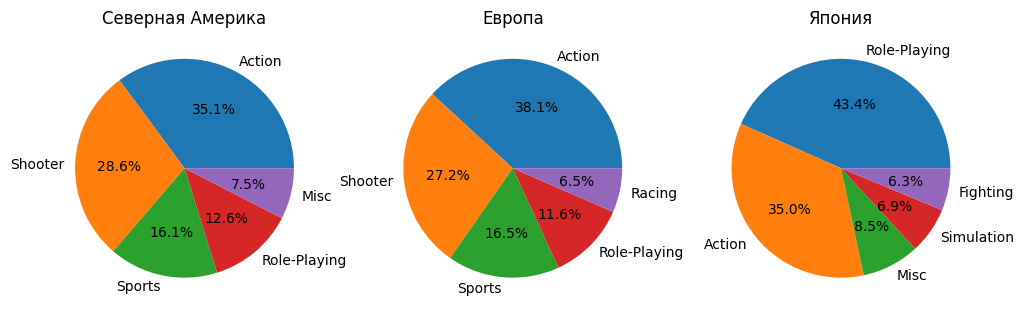

In [49]:
get_top_5('genre')

In [50]:
column = 'platform'
df_actual.groupby(column)['na_sales'].sum().sort_values(ascending = False).head(5)
data = df_actual.groupby(column)['na_sales'].sum().sort_values(ascending = False).head(5).values
names = (df_actual.groupby(column)['na_sales'].sum().sort_values(ascending = False).head(5).index)
names

Index(['X360', 'PS4', 'PS3', 'XOne', '3DS'], dtype='object', name='platform')

**В Северной Америке и Европе картина практически одинаковая - популярнее всего экшны и шутеры, спортивные игры и РПГ.**

**А вот на Японском рынке ситуация иная - в лидерах по продажам (с очень большим отрывом) РПГ и экшны, пятёрку замыкают симуляторы и файтинги**

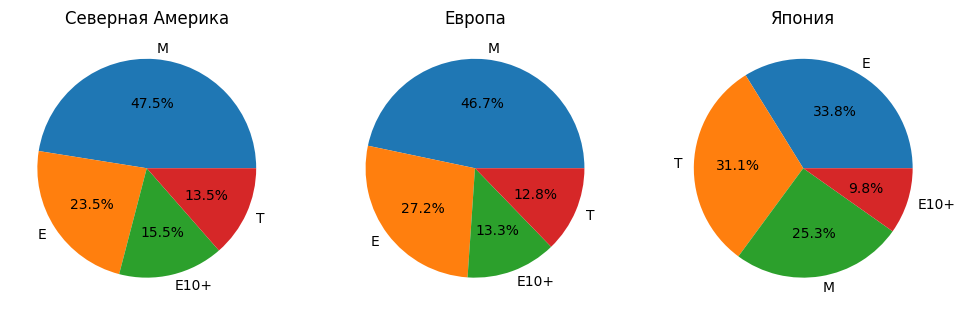

In [51]:
get_top_5('rating')

**Снова западные пользователи показывают схожее поведение - популярнее всего игры с рейтингом М (Mature, 17+) и Е (Everyone, для всех возрастов). Игры с рейтингом E10+ (10+) и Т (13+) имеют примерно одинаковую популярность.**

**В Японии же ситуация несколько иная - на первых местах рейтинг Е и Т**

# 5. Статистический анализ

In [52]:
def H0_test(pvalue, alpha):
    if pvalue > alpha:
        print(f'p-value ({pvalue:.2f}) > alpha ({alpha}), не получилось отвергнуть нулевую гипотезу')
    else:
        print(f'p-value ({pvalue:.2f}) < alpha ({alpha}), отвергаем нулевую гипотезу')

Проверим предположение о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую и альтернативную гипотезы:
- Н0: средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Н1: средние пользовательские рейтинги платформ Xbox One и PC отличаются

Уровень значимости установим 5%.

Для проверки будем использовать тест на равенство средних двух генеральных совокупностей

In [53]:
alpha = 0.05
H0_test(
    st.ttest_ind(df_actual[df_actual['platform'] == 'XOne']['user_score'].dropna(),
                 df_actual[df_actual['platform'] == 'PC']['user_score'].dropna()).pvalue,
    alpha)

p-value (0.55) > alpha (0.05), не получилось отвергнуть нулевую гипотезу


Проверим предположение о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем нулевую и альтернативную гипотезы:
- Н0: средние пользовательские жанров Action и Sports одинаковые
- Н1: средние пользовательские жанров Action и Sports отличаются

Уровень значимости установим 5%.

Для проверки будем использовать тест на равенство средних двух генеральных совокупностей

In [54]:
H0_test(
    st.ttest_ind(df_actual[df_actual['genre'] == 'Action']['user_score'].dropna(),
                 df_actual[df_actual['genre'] == 'Sports']['user_score'].dropna()).pvalue,
    alpha)

p-value (0.00) < alpha (0.05), отвергаем нулевую гипотезу


# 6. Выводы и рекомендации

Изучены данные о продажах видеоигр с 1980 по 2016 год.
- Проведена предобработка данных:
    - удалены данные с отсутствующим годом релиза (~2% данных)
    - тип данных столбца `year_of_release` приведён к целочисленному
    - некорректные значения 'tbd'в столбце `user_score` заменены на `None` (вероятнее всего в источнике данных таким образом помечались игры без рейтинга)
    - тип данных столбца `user_score` приведён к `float`
- Расчитаны суммарные продажи
- Изучена динамика продаж по годам. Выявлен резкий спад продаж после 2009 года (вероятнее всего из-за кризиса 2008 года и его последствий). После 2012 года продажи относительно стабилизировались, поэтому дальнейший анализ производился на данных с 2012 года
- На всех платформах выявлено одинаковое изменение продаж в течении их жихненного цикла - набор популярности примерно до его середины с последующим постепенным спадом. Средняя продолжительность жизни платформы - 10 лет
- Для всех актуальных платформ на данный момент характерен спад продаж. Потенциально наиболее прибыльными являются PS4 и Xbox One, однако на PS4 более вероятно появление игр с высокими продажами
- Установлена слабая прямая связь между оценками критиков и продажами. Однозначной связи между оценками пользователей и продажами установить не удалось
- Изучено распределение продаж по жанрам. Наибольшие продажи (средние и медианные) показывают шутеры, платформеры, спортивные игры и РПГ
- Составлен "портрет" пользователя по регионам
    - в Северной Америке и Европе домашние консоли намного популярнее портативных (в Североамериканском регионе лидирует Xbox 360, в Европе - PS4. В Японии портативные консоли более популярны (на первом месте по продажам игры для 3DS), а консоли Xbox не вошли в пятёрку лидеров
    - по жанрам в Северной Америке и Европе лидируют игры жанров экшн, шутер и спорт. В Японии с большим отрывом лидируют РПГ
    - наибольшей популярностью у западных игроков пользуются игры с рейтингами М, Е, Е10+ и Т. В Японии - Е, Т, М, Е10+.
- Проверена гипотеза о равенстве средних пользовательских рейтингов на XBox One и PC. Опровергнуть данную гипотезу не удалось.
- Проверена гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports. Данная гипотеза опровергнута

В целом, в 2017 году в Европейском и Североамериканском регионах рекомедуется сосредоточиться на играх для Xbox One и PS4, в Японии - на 3DS и PS4.

Если говорить о жанрах, то стоит отдавать приоритет шутерам, спортивным играм и платформерам